In [377]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

In [378]:
def roda_modelo(modelo, dados):

    y = dados['ICU']
    x = dados.drop(['ICU','WINDOW','PATIENT_VISIT_IDENTIFIER'], axis=1)
    
    x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, stratify=y, random_state=3465)

    modelo.fit(x_treino, y_treino)
    predicao = modelo.predict(x_teste)
    prob_predic = modelo.predict_proba(x_teste)

    auc = roc_auc_score(y_teste, prob_predic[:,1])
    print(f"AUC - área sob a curva ROC (Característica de Operação do Receptor): {auc:.2%}")
    print("\nClassification Report")
    print(classification_report(y_teste, predicao))
    false_positive_rates, true_positive_rates, thresholds = roc_curve(y_teste, predicao)
    return modelo, false_positive_rates, true_positive_rates

In [341]:
dados = pd.read_excel("https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")

In [342]:
print("Tratamento da Base 1")

pacientes_UTI = dados[['PATIENT_VISIT_IDENTIFIER','ICU']].query('ICU == 1').groupby('PATIENT_VISIT_IDENTIFIER').min()
dados_tratados = dados.query('ICU != 1').drop('ICU', axis=1)
dados_tratados = dados_tratados.join(pacientes_UTI, on='PATIENT_VISIT_IDENTIFIER', how='left')
dados_tratados['ICU'] = dados_tratados['ICU'].fillna(0) 
print("\nRemovemos as linhas com ICU(UTI) igual a 1 e remarcamos a coluna com base no PATIENT_VISIT_IDENTIFIER que chegou na UTI")
print(f"Distribuição de ICU na base tratada (%)\n{dados_tratados['ICU'].value_counts(normalize=True)*100}")

features_continuas_colunas = dados_tratados.iloc[:, 13:-2].columns
features_continuas = dados_tratados.groupby("PATIENT_VISIT_IDENTIFIER",as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
features_categoricas = dados_tratados.iloc[:, :13]
saida = dados_tratados.iloc[:, -2:]
dados_tratados = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
dados_tratados.columns = dados.columns
print("\nAjustamos os valores continuos que estavam com Nam para o valor anterior ou posterior")

descricao = dados_tratados.describe().T
colunas_sem_variacao = descricao[descricao['min'] == descricao['max']].index
if len(colunas_sem_variacao) !=0:
  dados_tratados.drop(colunas_sem_variacao, axis=1)
  print("\nRemovemos as colunas que os valores são iguais para todas as linhas")

colunas_categoricas = list(set(dados_tratados.columns)-set(dados_tratados.describe().columns)-{'WINDOW'})
colunas_categoricas
if len(colunas_categoricas) ==1:
  LE = preprocessing.LabelEncoder()
  LE.fit(np.ravel(dados_tratados[colunas_categoricas]))
  dados_tratados[colunas_categoricas] = LE.transform(np.ravel(dados_tratados[colunas_categoricas]))
  print(f"\nColuna com objeto categórico ({colunas_categoricas[0]}) foi transformada em numérica")
else:
  print(f"\nColunas com objetos categóricos precisam ser tratados: {', '.join(colunas_categoricas)}")


linhas_com_nam = dados_tratados.describe(include='all').loc['count'].max()-dados_tratados.describe(include='all').loc['count'].min()
if linhas_com_nam !=0:
  if linhas_com_nam <= len(dados_tratados)*.1:
    dados_tratados.dropna(inplace=True)
    print(f"\nAs linhas ainda com Nam ({linhas_com_nam} linhas, {linhas_com_nam/len(dados_tratados):.2%} do total) foram eliminadas")
  else:
    print(f"\nTemos linhas ainda com Nam ({linhas_com_nam} linhas, {linhas_com_nam/len(dados_tratados):.2%} do total) precisam ser tratadas")

dados_tratados.reset_index(drop=True, inplace=True)
print(f"\nO index foi resetado: {dados_tratados.index}")

print(f"\nFormato final do DataFrame dados_tratados: {dados_tratados.shape}")

Tratamento da Base 1

Removemos as linhas com ICU(UTI) igual a 1 e remarcamos a coluna com base no PATIENT_VISIT_IDENTIFIER que chegou na UTI
Distribuição de ICU na base tratada (%)
0.0    67.375887
1.0    32.624113
Name: ICU, dtype: float64

Ajustamos os valores continuos que estavam com Nam para o valor anterior ou posterior

Removemos as colunas que os valores são iguais para todas as linhas

Coluna com objeto categórico (AGE_PERCENTIL) foi transformada em numérica

As linhas ainda com Nam (5.0 linhas, 0.36% do total) foram eliminadas

O index foi resetado: RangeIndex(start=0, stop=1405, step=1)

Formato final do DataFrame dados_tratados: (1405, 231)


In [343]:
print(f"Segunda Base Tratada")

age_percentil = np.array(dados_tratados['AGE_PERCENTIL']).reshape(-1, 1)
age_percentil_OHE = pd.DataFrame(OHE.fit_transform(age_percentil).toarray())
dados_tratados_OHE = pd.concat([dados_tratados.drop('AGE_PERCENTIL', axis=1), age_percentil_OHE], ignore_index=True, axis=1)
colunas = list(dados_tratados.columns)
colunas.remove('AGE_PERCENTIL')
colunas_novas = list(dados['AGE_PERCENTIL'].unique())
colunas_novas.sort()
colunas.extend(colunas_novas)
dados_tratados_OHE.columns = colunas
print(f"\nTrocamos o campo AGE_PERCENTIL pelos campos binários {', '.join(colunas_novas)}")

print(f"\nFormato final do DataFrame dados_tratados_OHE: {dados_tratados_OHE.shape}")

Segunda Base Tratada

Trocamos o campo AGE_PERCENTIL pelos campos binários 10th, 20th, 30th, 40th, 50th, 60th, 70th, 80th, 90th, Above 90th

Formato final do DataFrame dados_tratados_OHE: (1405, 240)


In [425]:
m_LR = LogisticRegression(max_iter=10000)
m_LR, fpr_LR, tpr_LR = roda_modelo(m_LR, dados_tratados.query('WINDOW == "0-2"'))

AUC - área sob a curva ROC (Característica de Operação do Receptor): 85.05%

Classification Report
              precision    recall  f1-score   support

         0.0       0.75      0.91      0.83        47
         1.0       0.87      0.66      0.75        41

    accuracy                           0.80        88
   macro avg       0.81      0.79      0.79        88
weighted avg       0.81      0.80      0.79        88



In [426]:
m_LR_OHE = LogisticRegression(max_iter=10000)
m_LR_OHE, fpr_LR_OHE, tpr_LR_OHE = roda_modelo(m_LR_OHE, dados_tratados_OHE.query('WINDOW == "0-2"'))

AUC - área sob a curva ROC (Característica de Operação do Receptor): 83.76%

Classification Report
              precision    recall  f1-score   support

         0.0       0.75      0.91      0.83        47
         1.0       0.87      0.66      0.75        41

    accuracy                           0.80        88
   macro avg       0.81      0.79      0.79        88
weighted avg       0.81      0.80      0.79        88



In [434]:
m_DTC = DecisionTreeClassifier(random_state=3587)
m_DTC, fpr_DTC, tpr_DTC = roda_modelo(m_DTC, dados_tratados.query('WINDOW == "0-2"'))

AUC - área sob a curva ROC (Característica de Operação do Receptor): 60.28%

Classification Report
              precision    recall  f1-score   support

         0.0       0.64      0.60      0.62        47
         1.0       0.57      0.61      0.59        41

    accuracy                           0.60        88
   macro avg       0.60      0.60      0.60        88
weighted avg       0.60      0.60      0.60        88



In [435]:
m_DTC_OHE = DecisionTreeClassifier(random_state=3587)
m_DTC_OHE, fpr_DTC_OHE, tpr_DTC_OHE = roda_modelo(m_DTC_OHE, dados_tratados_OHE.query('WINDOW == "0-2"'))

AUC - área sob a curva ROC (Característica de Operação do Receptor): 61.65%

Classification Report
              precision    recall  f1-score   support

         0.0       0.66      0.57      0.61        47
         1.0       0.57      0.66      0.61        41

    accuracy                           0.61        88
   macro avg       0.62      0.62      0.61        88
weighted avg       0.62      0.61      0.61        88



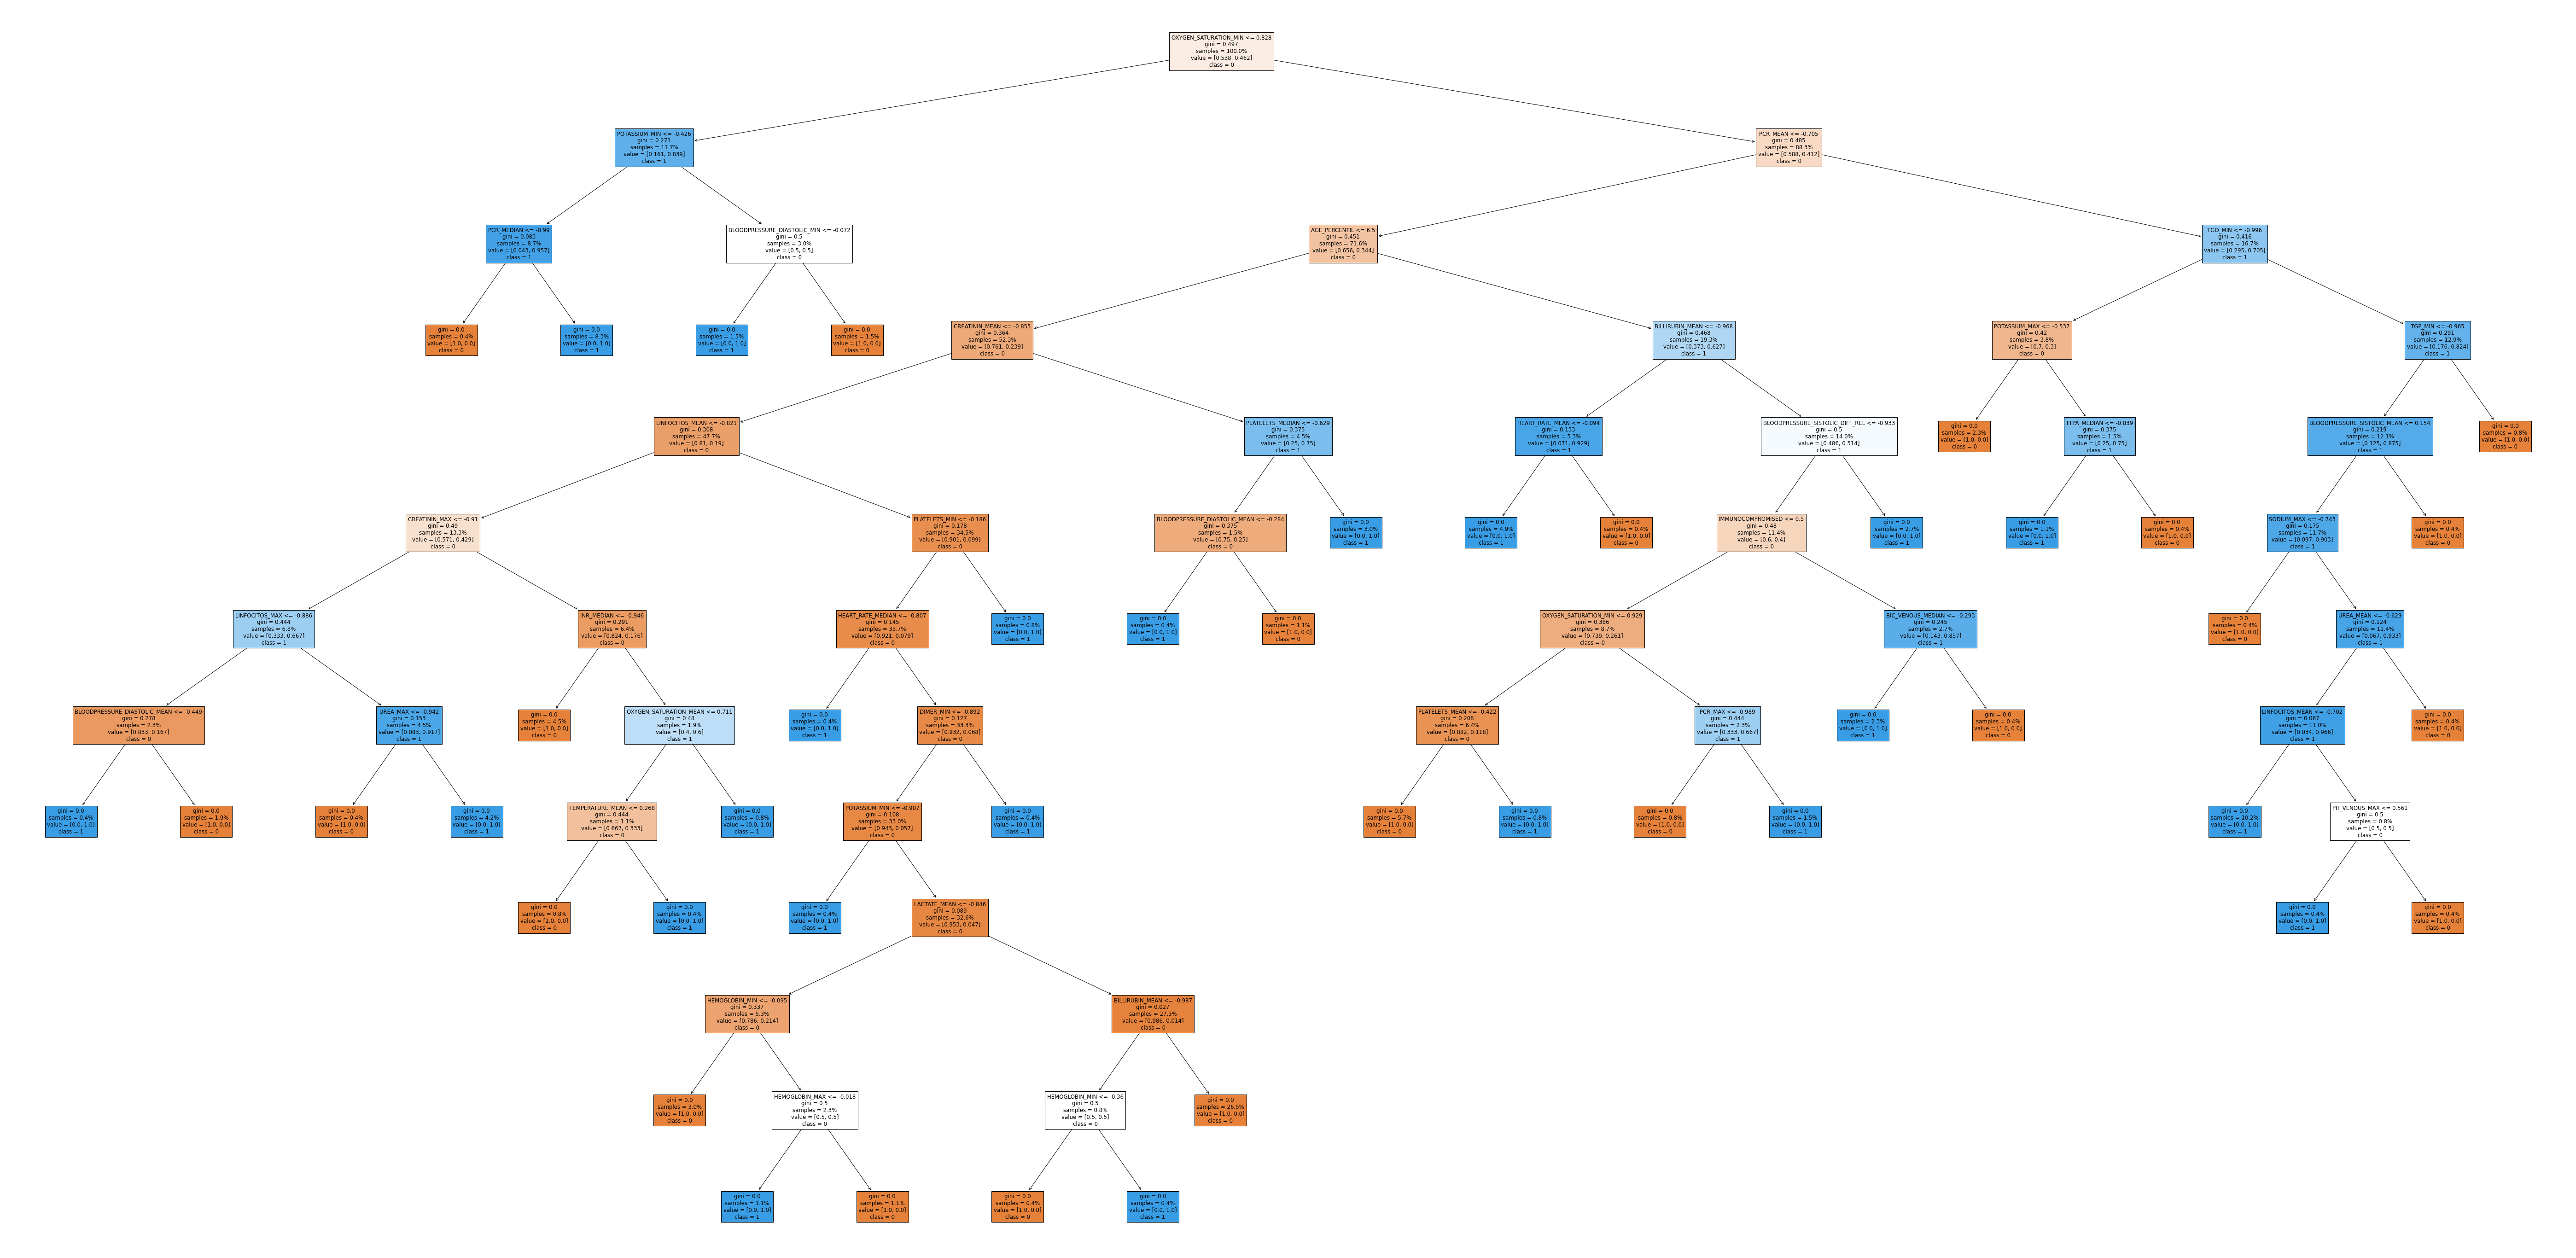

In [436]:
fig = plt.figure(figsize=(100,50))
_ = plot_tree(m_DTC, feature_names=dados_tratados.drop(['ICU','WINDOW','PATIENT_VISIT_IDENTIFIER'], axis=1).columns,
              class_names=['0','1'], filled=True, proportion=True)
fig.savefig("decistion_tree.png")

In [437]:
print(export_text(m_DTC, show_weights=True, 
                  feature_names=list(dados_tratados.drop(['ICU','WINDOW','PATIENT_VISIT_IDENTIFIER'], axis=1).columns)))

|--- OXYGEN_SATURATION_MIN <= 0.83
|   |--- POTASSIUM_MIN <= -0.43
|   |   |--- PCR_MEDIAN <= -0.99
|   |   |   |--- weights: [1.00, 0.00] class: 0.0
|   |   |--- PCR_MEDIAN >  -0.99
|   |   |   |--- weights: [0.00, 22.00] class: 1.0
|   |--- POTASSIUM_MIN >  -0.43
|   |   |--- BLOODPRESSURE_DIASTOLIC_MIN <= -0.07
|   |   |   |--- weights: [0.00, 4.00] class: 1.0
|   |   |--- BLOODPRESSURE_DIASTOLIC_MIN >  -0.07
|   |   |   |--- weights: [4.00, 0.00] class: 0.0
|--- OXYGEN_SATURATION_MIN >  0.83
|   |--- PCR_MEAN <= -0.70
|   |   |--- AGE_PERCENTIL <= 6.50
|   |   |   |--- CREATININ_MEAN <= -0.85
|   |   |   |   |--- LINFOCITOS_MEAN <= -0.82
|   |   |   |   |   |--- CREATININ_MAX <= -0.91
|   |   |   |   |   |   |--- LINFOCITOS_MAX <= -0.89
|   |   |   |   |   |   |   |--- BLOODPRESSURE_DIASTOLIC_MEAN <= -0.45
|   |   |   |   |   |   |   |   |--- weights: [0.00, 1.00] class: 1.0
|   |   |   |   |   |   |   |--- BLOODPRESSURE_DIASTOLIC_MEAN >  -0.45
|   |   |   |   |   |   |   |   |--- 

In [438]:
def plota_curva_ROC(fpr, tpr, labels):
  for i in range(0,len(labels)):
    plt.plot(fpr[i],tpr[i], label=labels[i])
  plt.legend(loc=4)
  plt.show()

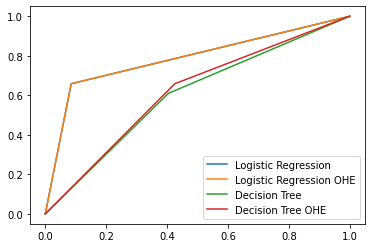

In [440]:
plota_curva_ROC([fpr_LR,fpr_LR_OHE,fpr_DTC,fpr_DTC_OHE],[tpr_LR,tpr_LR_OHE,tpr_DTC,tpr_DTC_OHE],
                ['Logistic Regression','Logistic Regression OHE','Decision Tree','Decision Tree OHE'])